In [1]:
cd /content/drive/MyDrive/AutoColoringAI/

/content/drive/MyDrive/AutoColoringAI


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torch.optim import Adam

In [3]:
from PIL import Image

In [4]:
import numpy as np

In [5]:
import os
import warnings
warnings.filterwarnings("ignore")

In [6]:
!nvidia-smi

Tue Oct 19 11:57:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
classification_vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

classification_vgg.eval()

classification_vgg.load_state_dict(torch.load("./vgg_normalised.pth"))

device = torch.device("cuda")
classification_vgg.to(device)

classification_vgg = nn.Sequential(*list(classification_vgg.children())[:31])


for p in classification_vgg.parameters():
    p.requires_grad = False

In [8]:
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.vgg = classification_vgg

        self.fc1 = nn.Linear(512 * 16 * 16, 100, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(100, 50, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

        self.fc3 = nn.Linear(50, 3, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.vgg(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.relu(out)

        return out

In [9]:
!pip install pickle5

     |████████████████████████████████| 132 kB 5.3 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219282 sha256=0dc6cc3fcdec283fbced23e0605d81f4cd63c2fe52ad12ea4dcc27207bb8542b
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [10]:
import pickle5 as pickle

with open('./pkl_/train_x.pkl', 'rb') as f:
	train_x = pickle.load(f)
 
with open('./pkl_/train_y.pkl', 'rb') as f:
	train_y = pickle.load(f)
 
with open('./pkl_/validation_x.pkl', 'rb') as f:
	validation_x = pickle.load(f)
 
with open('./pkl_/validation_y.pkl', 'rb') as f:
	validation_y = pickle.load(f)

In [11]:
validation_dataset = TensorDataset(validation_x, validation_y)
validation_dataloader = DataLoader(validation_dataset, batch_size=60, shuffle=True)

def get_validation_loss(model):
  avg_loss = 0
  criterion = nn.CrossEntropyLoss().to(device)

  for x, y in validation_dataloader:
    x = x.to(device)
    y = y.to(device)

    pred = model(x)
    loss = criterion(pred, y)

    avg_loss += loss

  avg_loss /= 600

  return avg_loss

In [12]:
dataset = TensorDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=120, shuffle=True)

In [13]:
art_classification = Classification().to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer = Adam(art_classification.parameters(), lr=0.002)

epoch: 0, avg_loss: 0.20864956080913544, validation_loss: 0.18643958866596222
epoch: 1, avg_loss: 0.020567752420902252, validation_loss: 0.12808164954185486
epoch: 2, avg_loss: 0.013404890894889832, validation_loss: 0.1802823394536972
epoch: 3, avg_loss: 0.007199157029390335, validation_loss: 0.08976566791534424
epoch: 4, avg_loss: 0.0038929376751184464, validation_loss: 0.0529908686876297
epoch: 5, avg_loss: 0.0027671658899635077, validation_loss: 0.0701344832777977
epoch: 6, avg_loss: 0.002071795519441366, validation_loss: 0.044726137071847916
epoch: 7, avg_loss: 0.0013412092812359333, validation_loss: 0.05584399774670601
epoch: 8, avg_loss: 0.001072476850822568, validation_loss: 0.04814872890710831
epoch: 9, avg_loss: 0.0009977867593988776, validation_loss: 0.061573851853609085
best epoch: 6


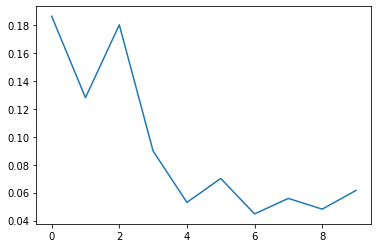

In [14]:
import matplotlib.pyplot as plt

validation_loss_log = []

weights_log = []

for epoch in range(10):
    avg_loss = 0
    
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        pred = art_classification(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
        
    validation_loss_log.append(get_validation_loss(art_classification))
    weights_log.append(art_classification.state_dict())
        
    avg_loss /= 16200
    print(f"epoch: {epoch}, avg_loss: {avg_loss}, validation_loss: {validation_loss_log[-1]}")
  
  
plt.plot([i for i in range(10)], validation_loss_log)
print(f"best epoch: {validation_loss_log.index(min(validation_loss_log))}")

In [15]:
torch.save(weights_log[6], "art_classification.pkl")

In [16]:
import pickle5 as pickle
import numpy as np

model = Classification().to(device)
model.load_state_dict(torch.load("art_classification.pkl"))


with open('./pkl_/test_x.pkl', 'rb') as f:
	test_x = pickle.load(f)
 
with open('./pkl_/test_y.pkl', 'rb') as f:
	test_y = pickle.load(f)

test_acc = 0

test_dataset = TensorDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=60, shuffle=True)

for x, y in test_dataloader:
  x = x.to(device)
  y = y.numpy()

  pred = model(x)
  pred = pred.cpu().detach().numpy()
  pred = np.array([np.argmax(i) for i in pred])
  test_acc += sum((pred == y).astype(np.uint64))

test_acc /= 1800

print(test_acc)

0.8188888888888889
